<a href="https://colab.research.google.com/github/Jivitesh2001/NYC-Taxi-Trip-Duration/blob/main/NYC_Taxi-Trip_%20Duration(Predictive_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC Taxi Trip Duration Model

## Importng Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime 
import math
import statsmodels.api as sm 
import pylab as py 

from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
import warnings 
warnings.filterwarnings(action = 'ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [2]:
data1 = pd.read_csv('/content/drive/MyDrive/data/nyc_taxi_trip_duration.csv')
data = data1

In [3]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [4]:
data.shape

(729322, 11)

In [5]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

## Checking Missing Values

In [6]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no missing values in this dataset

## Variable Identification and Typecasting

In [7]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

### Int Datatypes

In [8]:
data.dtypes[data.dtypes == 'int64']

vendor_id          int64
passenger_count    int64
trip_duration      int64
dtype: object

* trip_duration is the target variable.
* vendor_id should be converted into a categorical variable.
* passenger_count should be converted into categorical variable.

In [9]:
data['vendor_id'] = data['vendor_id'].astype('category')
data['passenger_count'] = data['passenger_count'].astype('category')

### Float Datatypes

In [10]:
data.dtypes[data.dtypes == 'float64']


pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
dtype: object

These variables will be used for calculating the distance from pickup location to dropoff location 

### Object Datatypes

In [11]:
data.dtypes[data.dtypes == 'object']


id                    object
pickup_datetime       object
dropoff_datetime      object
store_and_fwd_flag    object
dtype: object

* id is a unique code assigned to a taxi trip. It does not provide any information about the data, so it can be dropped from the dataset.
*pickup_date and dropoff datetime should be converted into a datetime variable.

In [12]:
data = data.drop(columns = ['id'])

### Datetime variables

In [13]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [14]:
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


Segregating these datetime variables into smaller variables.

#### For pickup

In [15]:
# week of the year of pickup
data['woy_pickup'] = data['pickup_datetime'].dt.weekofyear

# month of the year of pickup
data['moy_pickup'] = data['pickup_datetime'].dt.month

# day of the week of pickup
data['dow_pickup'] = data['pickup_datetime'].dt.dayofweek

# hour of the day of pickup
data['hod_pickup'] = data['pickup_datetime'].dt.hour

#### For dropoff

In [16]:

# week of the year of dropoff
data['woy_dropoff'] = data['dropoff_datetime'].dt.weekofyear

# month of the year of dropoff
data['moy_dropoff'] = data['dropoff_datetime'].dt.month

# day of the week of dropoff
data['dow_dropoff'] = data['dropoff_datetime'].dt.dayofweek

# hour of the day of dropoff
data['hod_dropoff'] = data['dropoff_datetime'].dt.hour

Changing day of week, month of year and week of year into a categorical variables.

In [17]:
# for pickup
data['dow_pickup'] = data['dow_pickup'].astype('category') 
data['woy_pickup'] = data['woy_pickup'].astype('category')
data['moy_pickup'] = data['moy_pickup'].astype('category')
# for dropoff
data['dow_dropoff'] = data['dow_dropoff'].astype('category') 
data['woy_dropoff'] = data['woy_dropoff'].astype('category')
data['moy_dropoff'] = data['moy_dropoff'].astype('category')

In [18]:
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,woy_pickup,moy_pickup,dow_pickup,hod_pickup,woy_dropoff,moy_dropoff,dow_dropoff,hod_dropoff
0,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,9,2,0,16,9,2,0,16
1,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,10,3,4,23,10,3,4,23
2,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,7,2,6,17,7,2,6,18
3,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,1,1,1,9,1,1,1,10
4,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,7,2,2,6,7,2,2,6


Now drop pickup_datetime and dropoff_datetime variables.

In [19]:
data = data.drop(columns = ['pickup_datetime','dropoff_datetime'])

In [20]:
data.dtypes

vendor_id             category
passenger_count       category
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag      object
trip_duration            int64
woy_pickup            category
moy_pickup            category
dow_pickup            category
hod_pickup               int64
woy_dropoff           category
moy_dropoff           category
dow_dropoff           category
hod_dropoff              int64
dtype: object

In [21]:
#converting hours of the day into daytime and eveningtime
def tod(x):
    if x>=4 and x<12:
        return 'morning'
    elif x>=12 and x<17:
        return 'afternoon'
    elif x>=17 and x<21:
        return 'evening'
    else:
        return 'night'
    

In [22]:
data['timeofday_pickup'] = data['hod_pickup'].apply(lambda x : tod(x))

In [23]:
data['timeofday_dropoff'] = data['hod_dropoff'].apply(lambda x : tod(x))

In [24]:
data['timeofday_pickup'] = data['timeofday_pickup'].astype('category')
data['timeofday_dropoff'] = data['timeofday_dropoff'].astype('category')

Dropping columns hod_pickup and hod_dropoff 

In [25]:
data = data.drop(columns=['hod_pickup','hod_dropoff'])

In [26]:
data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,woy_pickup,moy_pickup,dow_pickup,woy_dropoff,moy_dropoff,dow_dropoff,timeofday_pickup,timeofday_dropoff
0,2,1,-73.953918,40.778873,-73.963875,40.771164,N,400,9,2,0,9,2,0,afternoon,afternoon
1,1,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,10,3,4,10,3,4,night,night
2,2,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,7,2,6,7,2,6,evening,evening
3,2,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,1,1,1,1,1,1,morning,morning
4,1,1,-74.017120,40.708469,-73.988182,40.740631,N,848,7,2,2,7,2,2,morning,morning


## Haversine Distance

Calculating haversine distance from the pickup and dropoff location.

In [27]:
def h_dist(param_data):
  # to calculate the distance between two location using their coordinates
    pickup_long = param_data['pickup_longitude']
    pickup_lat = param_data['pickup_latitude']
    dropoff_long= param_data['dropoff_longitude']
    dropoff_lat = param_data['dropoff_latitude']
    diff_lat = (pickup_lat - dropoff_lat) * math.pi / 180.0
    diff_long = (pickup_long - dropoff_long)* math.pi / 180.0
    
    pickup_lat = pickup_lat * math.pi / 180.0
    dropoff_lat = dropoff_lat * math.pi / 180.0
    
    a =  (pow(math.sin(diff_lat/2),2) + pow(math.sin(diff_long/2),2) * math.cos(pickup_lat) * math.cos(dropoff_lat))
    
    c = 2 * math.asin(math.sqrt(a))
    
    rad = 6371 # radius of earth 
    return c * rad

In [28]:
data['haversine_distance'] = data.apply(h_dist,axis =1)

Drop pickup and dropoff locations as we calculated the distance from these points.

In [29]:
data = data.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']) 

In [30]:
data.dtypes

vendor_id             category
passenger_count       category
store_and_fwd_flag      object
trip_duration            int64
woy_pickup            category
moy_pickup            category
dow_pickup            category
woy_dropoff           category
moy_dropoff           category
dow_dropoff           category
timeofday_pickup      category
timeofday_dropoff     category
haversine_distance     float64
dtype: object

## Univariate Analysis

### Numerical

In [31]:
data.select_dtypes(include=['int64','float64']).dtypes

trip_duration           int64
haversine_distance    float64
dtype: object

In [32]:
# function for unnivariate numerical analysis
def UVA_numeric(data,var_group):
    size = len(var_group)
    plt.figure(figsize=(8*size, 4),dpi=100)
    
    for j,i in enumerate(var_group):
        mini = data[i].min()
        maxi = data[i].max()
        rang = maxi - mini
        mean = data[i].mean()
        median = data[i].median()
        std_dev = data[i].std()
        skew = data[i].skew()
        kurtosis = data[i].kurtosis()
        
        # calculating points of standard deviation
        points = mean - std_dev, mean + std_dev
        
        # plotting all the variables with every info
        
        plt.subplot(1,size,j+1)
        sns.kdeplot(data[i],shade=True)
        sns.lineplot(points,[0,0],color ='black',label='std_dev')
        sns.scatterplot([mini,maxi],[0,0],color='orange',label = 'min/max')
        sns.scatterplot([mean],[0],color='red',label='mean')
        sns.scatterplot([median], [0], color = 'blue', label = "median")
        plt.xlabel('{}'.format(i), fontsize = 20)
        plt.ylabel('density')
        plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurtosis,2),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(rang,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))
        
        

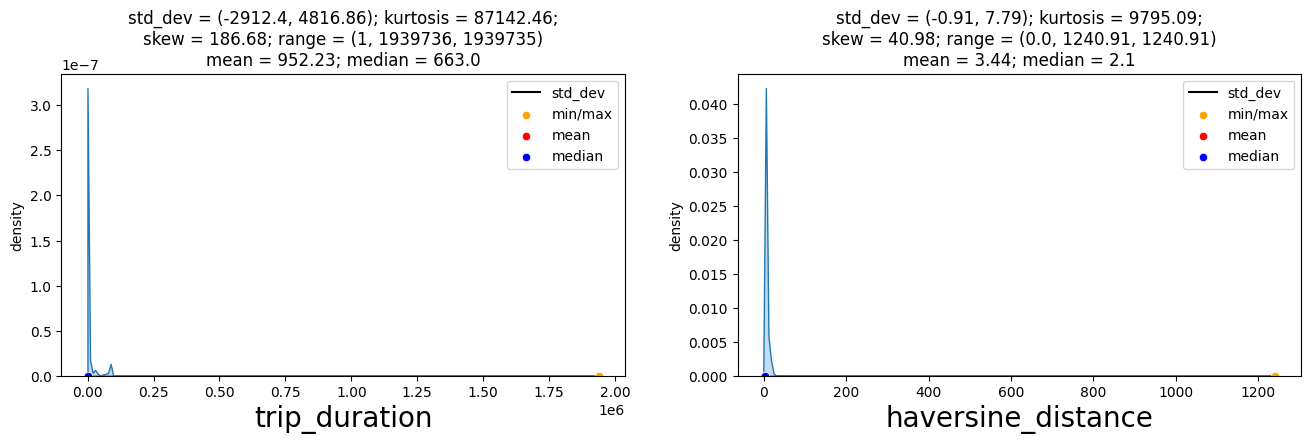

In [33]:
UVA_numeric(data,['trip_duration','haversine_distance'])

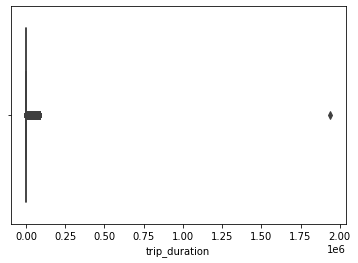

In [34]:
sns.boxplot(data['trip_duration'])

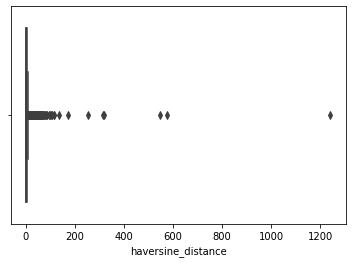

In [35]:
sns.boxplot(data['haversine_distance'])

There are a very large number of Outliers/Extreme values.

#### Outlier Removal

In [36]:
#function for outlier analysis
def UVA_outlier(data, var_group, include_outlier=True):
    '''This function takes a group of variable and it plots box plot and descriptives'''
    size = len(var_group)
    plt.figure(figsize = (7*size,4),dpi=100)
    
    
    #looping for each variable
    for j,i in enumerate(var_group):
        #calculating descriptives of variable(like IQR, 25th quantile, 75th quantile)
        quant25 = data[i].quantile(0.25)
        quant75 = data[i].quantile(0.75)
        IQR = quant75 - quant25
        med = data[i].median()
        whis_low = quant25 - (1.5 * IQR)
        whis_high = quant75 + (1.5 * IQR)
        
        outlier_high = len(data[i][data[i]>whis_high])
        outlier_low = len(data[i][data[i]<whis_low])
        
        if include_outlier == True:
            print(include_outlier)
            #plotting variable with outliers
            plt.subplot(1,size,j+1)
            sns.boxplot(data[i], orient = "v")
            plt.ylabel('{}'.format(i))
            plt.title('With Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))
            
      
        else:
            # replacing outliers with min/max whisker
            data2 = data[var_group][:]
            data2[i][data2[i]>whis_high] = whis_high 
            data2[i][data2[i]<whis_low] = whis_low 
            
            #plotting without outliers
            plt.subplot(1,size,j+1)
            sns.boxplot(data2[i], orient="v")
            plt.ylabel('{}'.format(i))
            plt.title('Without Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))
            

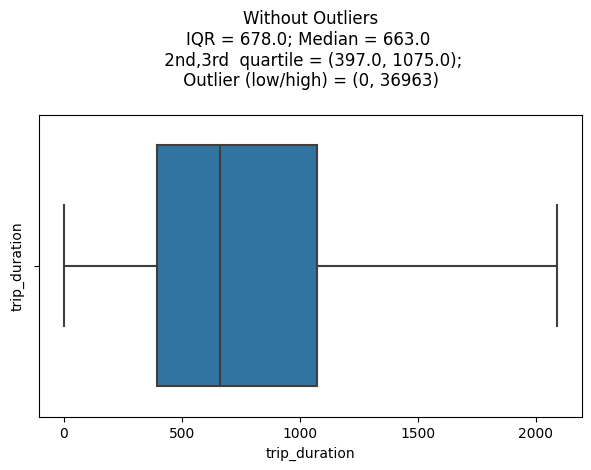

In [37]:
UVA_outlier(data,['trip_duration'],False)

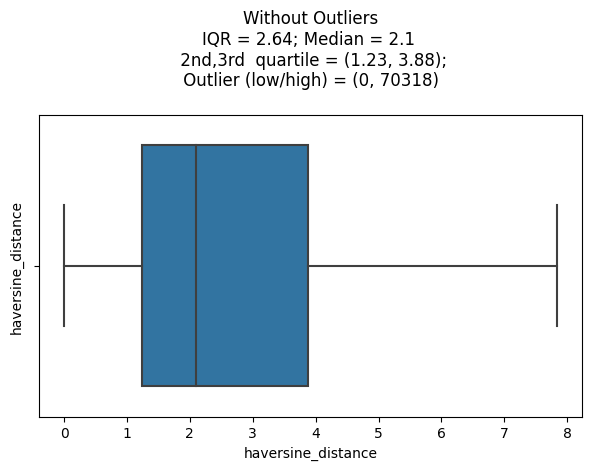

In [38]:
UVA_outlier(data,['haversine_distance'],False)

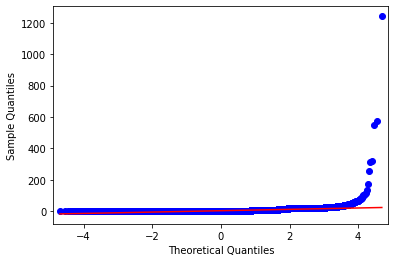

In [39]:
sm.qqplot(data['haversine_distance'],line ='s')
py.show()

There seems to be large and extreme outliers.

#### Removing outliers to get a better view of kde - plot

Taking values only within 3 standard deviations

In [40]:
factor = 3
hdist_data = data.loc[data.haversine_distance< factor * data.haversine_distance.std(),'haversine_distance']
hdist_data=hdist_data.reset_index()

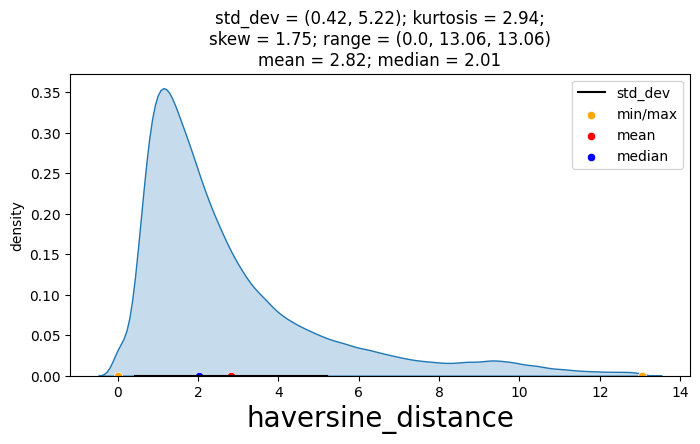

In [41]:
UVA_numeric(hdist_data,['haversine_distance'])

**Log Transformation**

In [42]:
  mini=1
  if hdist_data['haversine_distance'].min()<0:
    mini =  abs(hdist_data['haversine_distance'].min()) + 1
  
  hdist_data['log_dist'] = [i+mini for i in hdist_data['haversine_distance']]
  hdist_data['log_dist'] = hdist_data['log_dist'].map(lambda x : np.log(x))

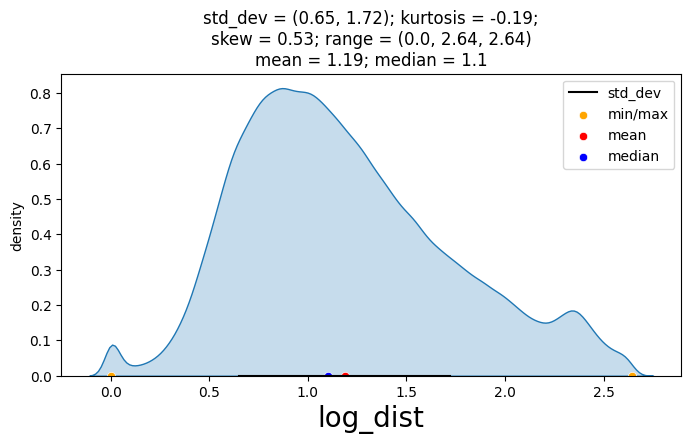

In [43]:
UVA_numeric(hdist_data,['log_dist'])

### Categorical

In [44]:
data.select_dtypes(include=['object','category']).dtypes

vendor_id             category
passenger_count       category
store_and_fwd_flag      object
woy_pickup            category
moy_pickup            category
dow_pickup            category
woy_dropoff           category
moy_dropoff           category
dow_dropoff           category
timeofday_pickup      category
timeofday_dropoff     category
dtype: object

In [45]:
#grouping variables
pickup_datetime = ['timeofday_pickup','woy_pickup','moy_pickup','dow_pickup',]
dropoff_datetime = ['timeofday_dropoff','woy_dropoff','woy_dropoff','dow_dropoff']
other_details = ['vendor_id','passenger_count','store_and_fwd_flag']

In [46]:
def UVA_category(data, var_group):
   
  size = len(var_group)
  plt.figure(figsize = (7*size,5), dpi = 100)

  
  for j,i in enumerate(var_group):
    norm_count = data[i].value_counts(normalize = True)
    n_uni = data[i].nunique()
   
    plt.subplot(1,size,j+1)
    sns.barplot(norm_count.index, norm_count,orient='v' ) #, order = norm_count.index)
    plt.xlabel('fraction/percent', fontsize = 20)
    plt.ylabel('{}'.format(i), fontsize = 20)
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))

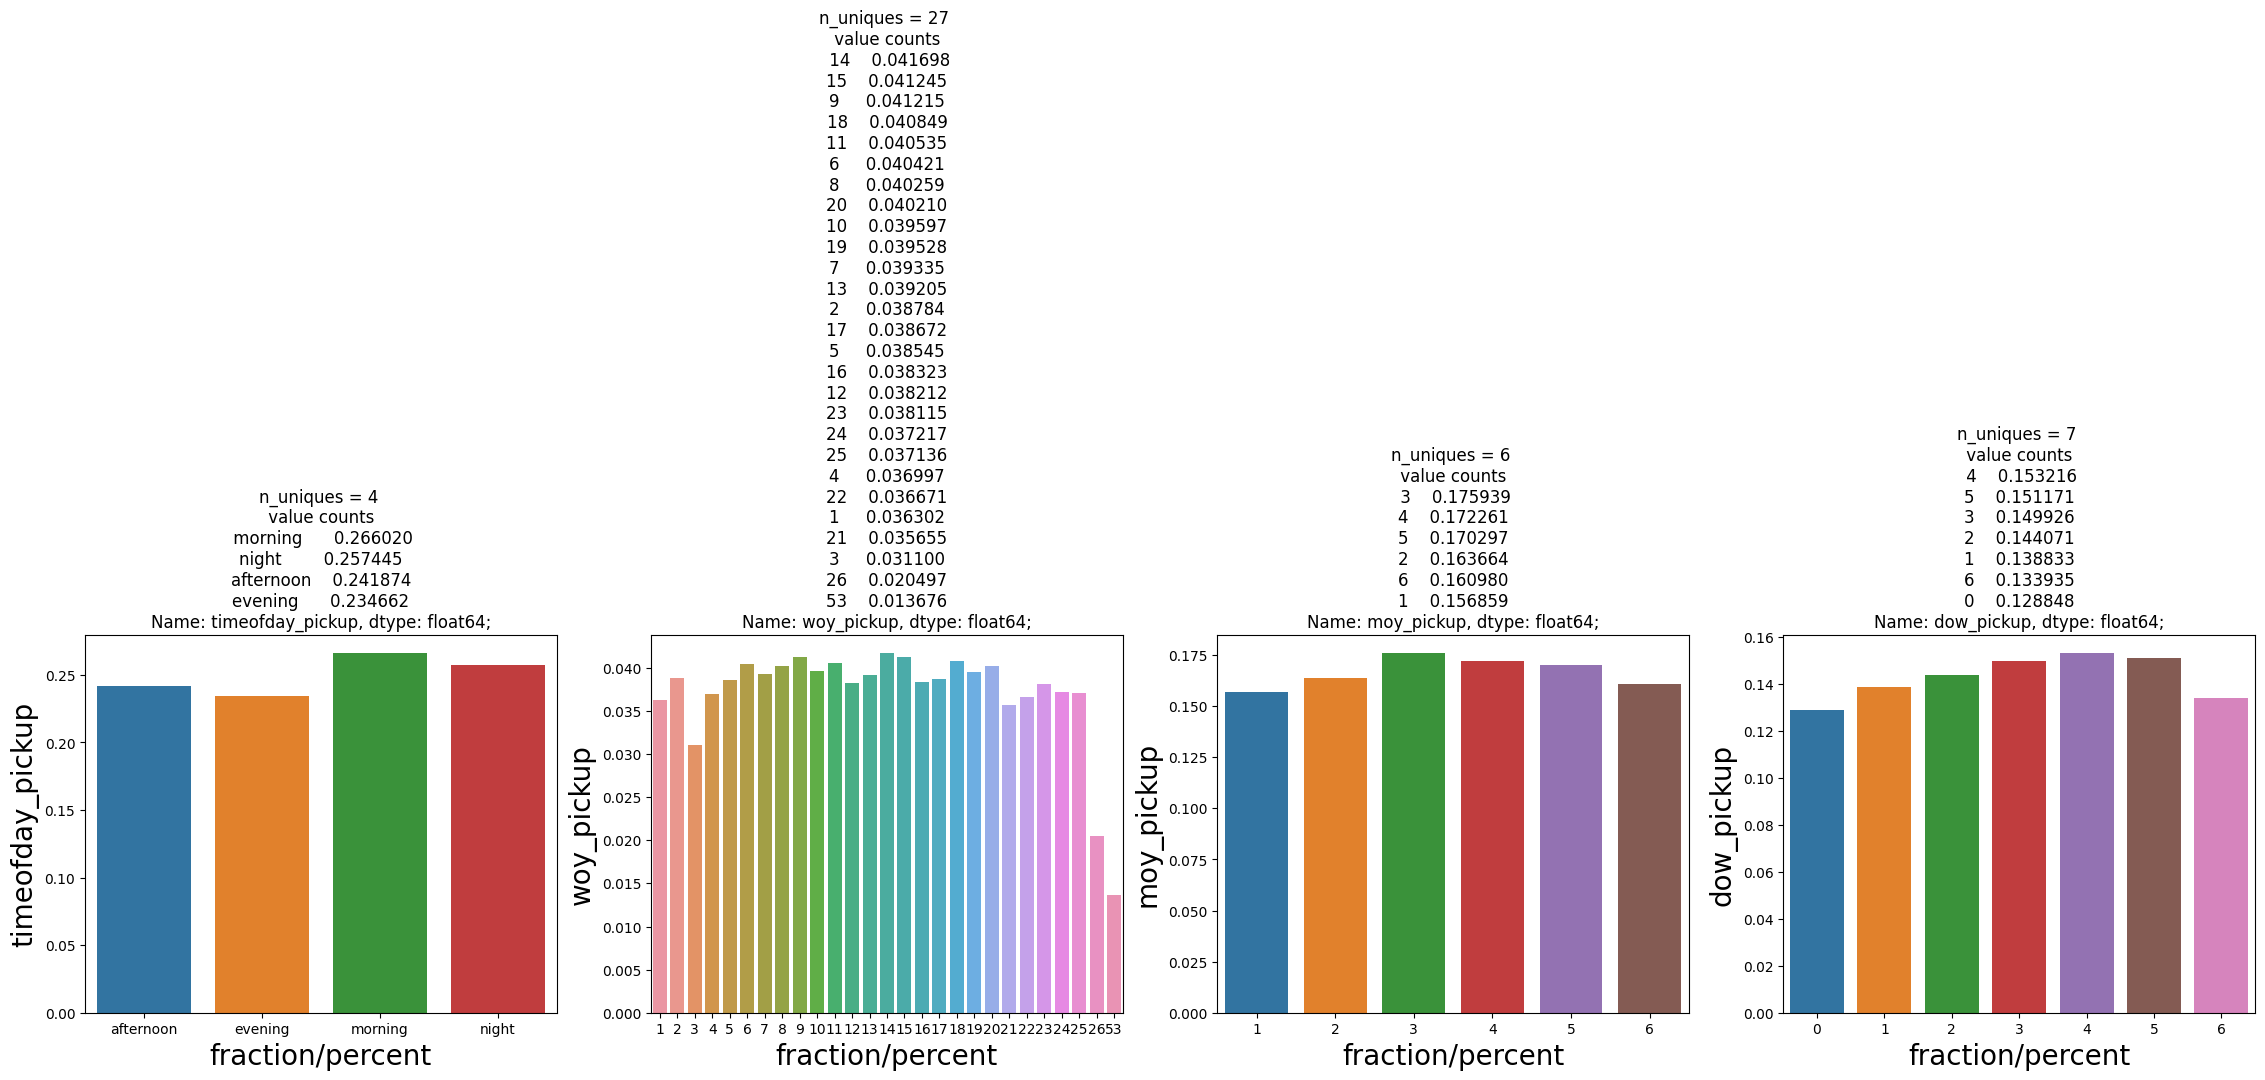

In [47]:
UVA_category(data,pickup_datetime)

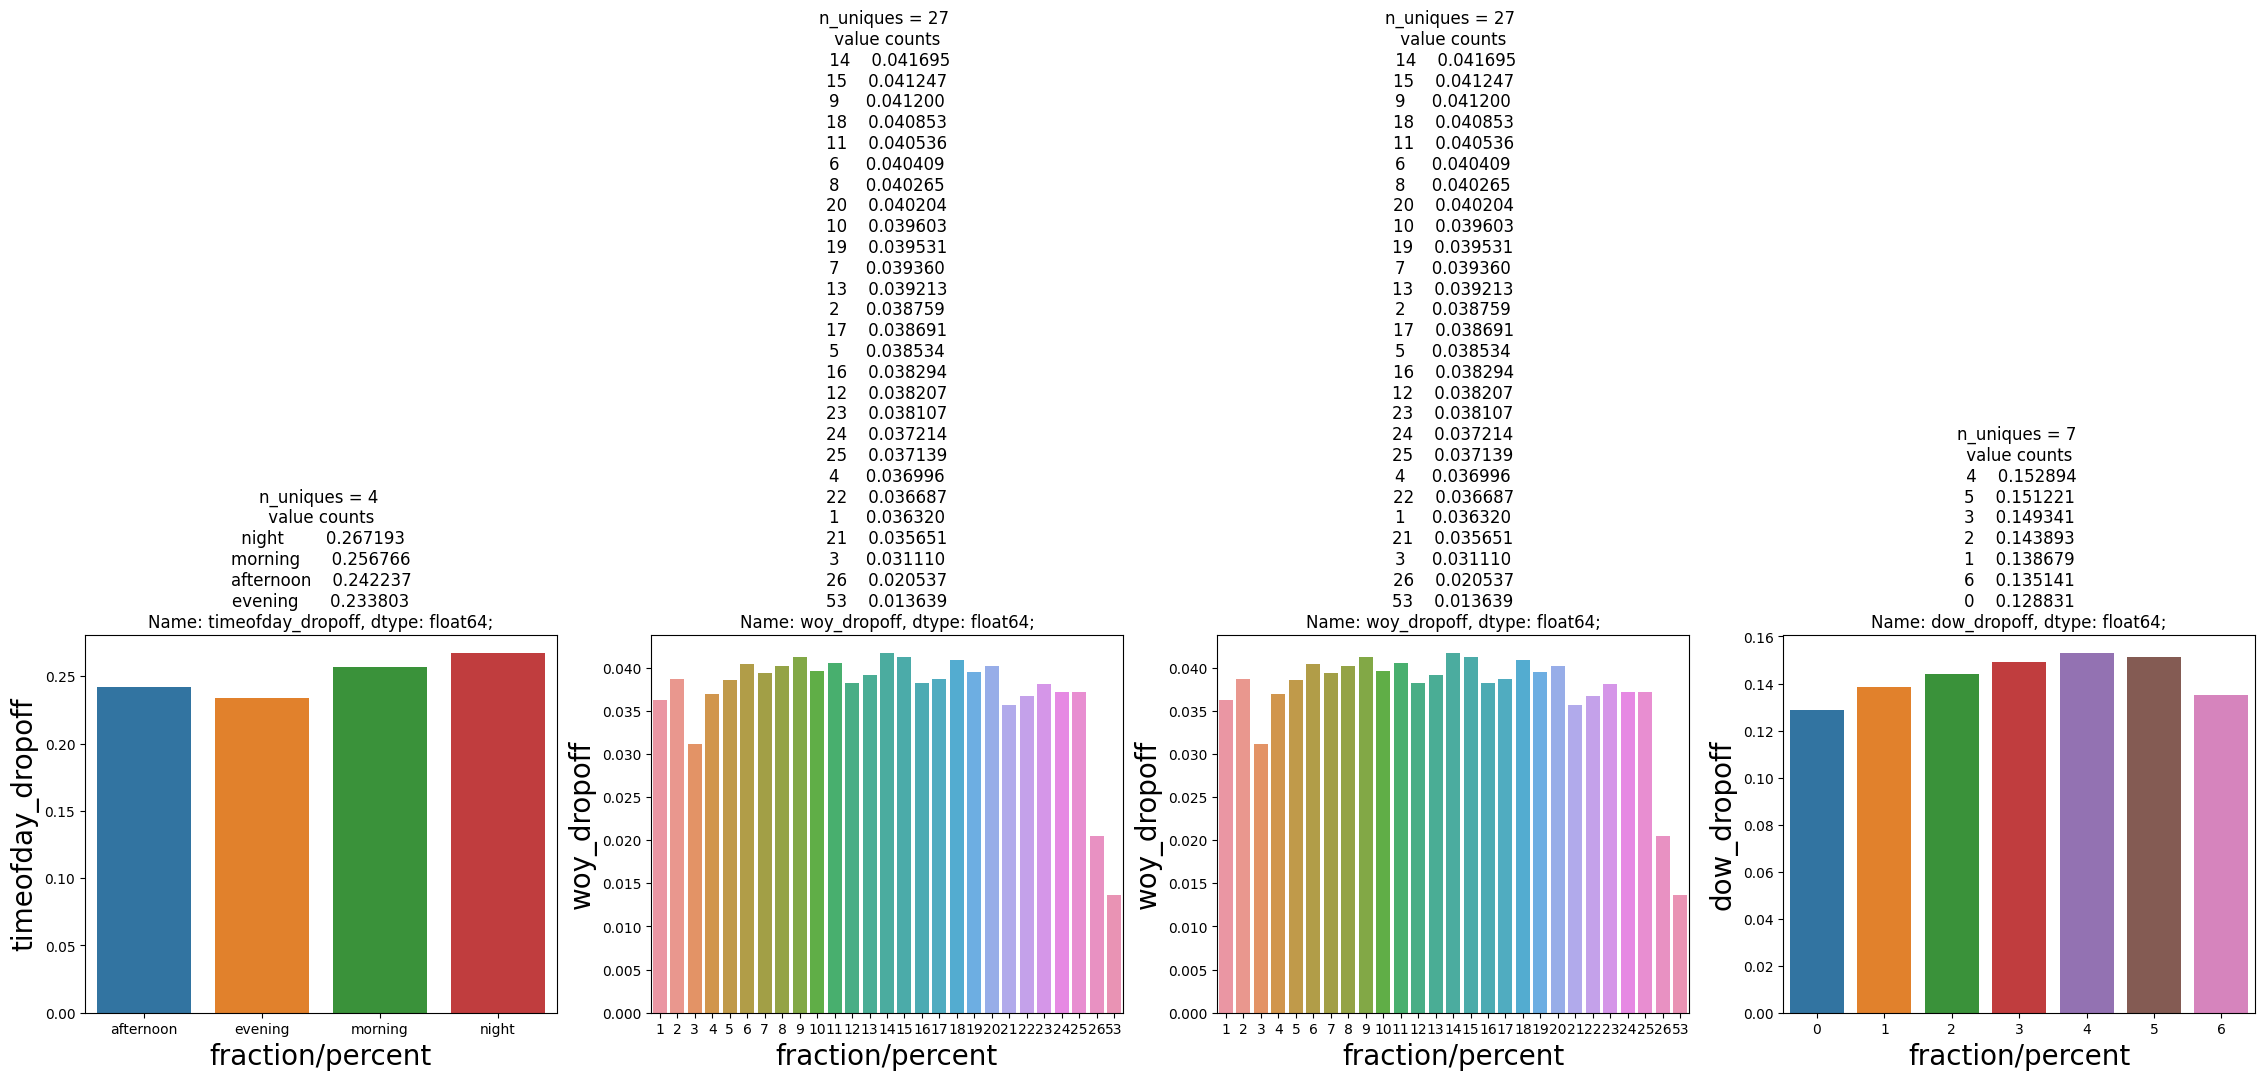

In [48]:
UVA_category(data,dropoff_datetime)

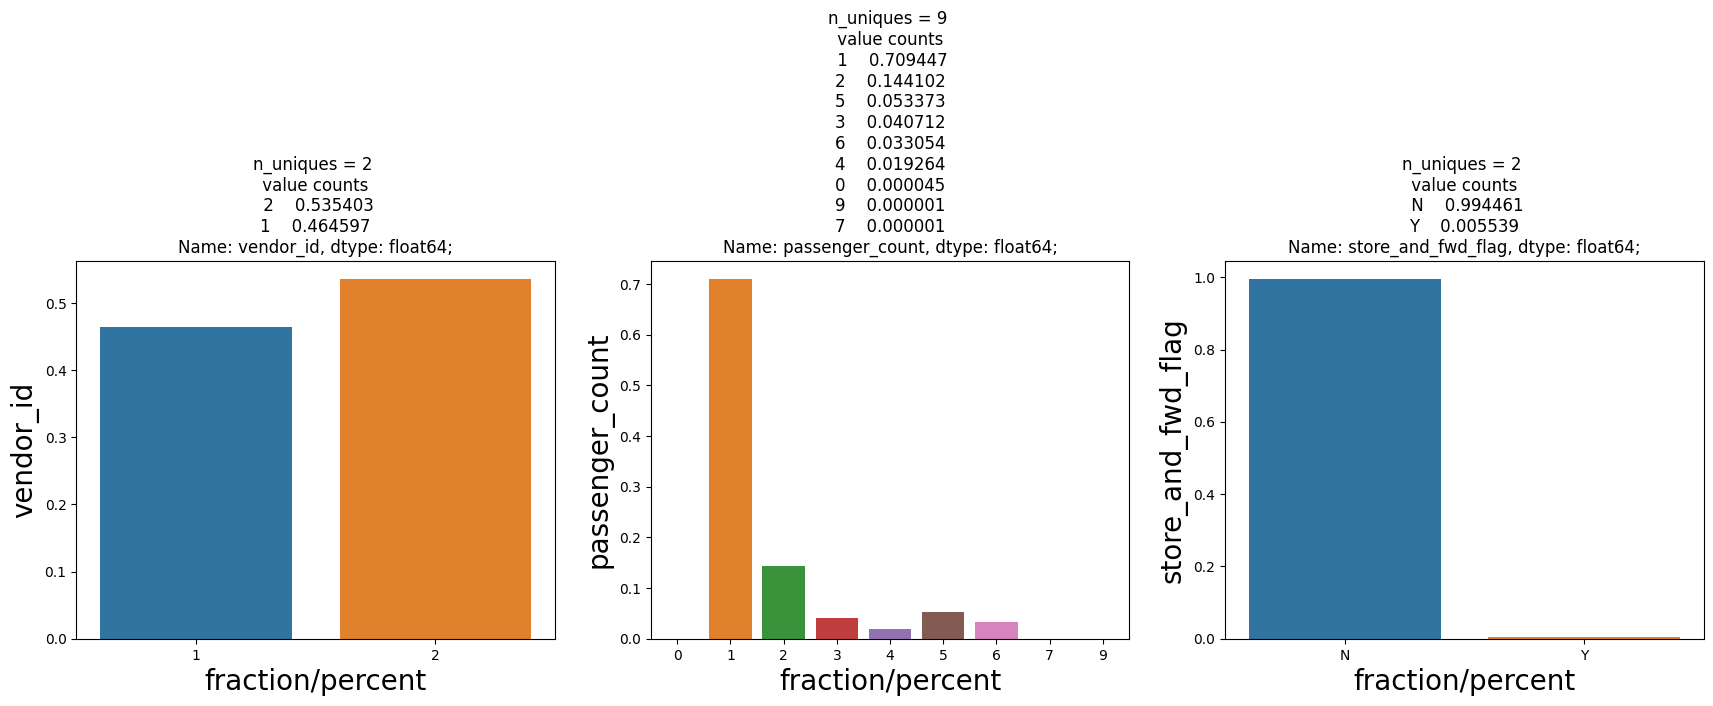

In [49]:
UVA_category(data,other_details)

## Bivariate Analysis

### Continous - Continous 

In [50]:
#selecting all continous variables
#continous = data.sample(frac=0.1,replace=True,random_state=7)
continous = data.select_dtypes(include=['int64','float64'])

In [51]:
correlation = continous.corr(method='spearman')
correlation

,trip_duration,haversine_distance
trip_duration,1.000000,0.794529
haversine_distance,0.794529,1.000000


#### Heatmap

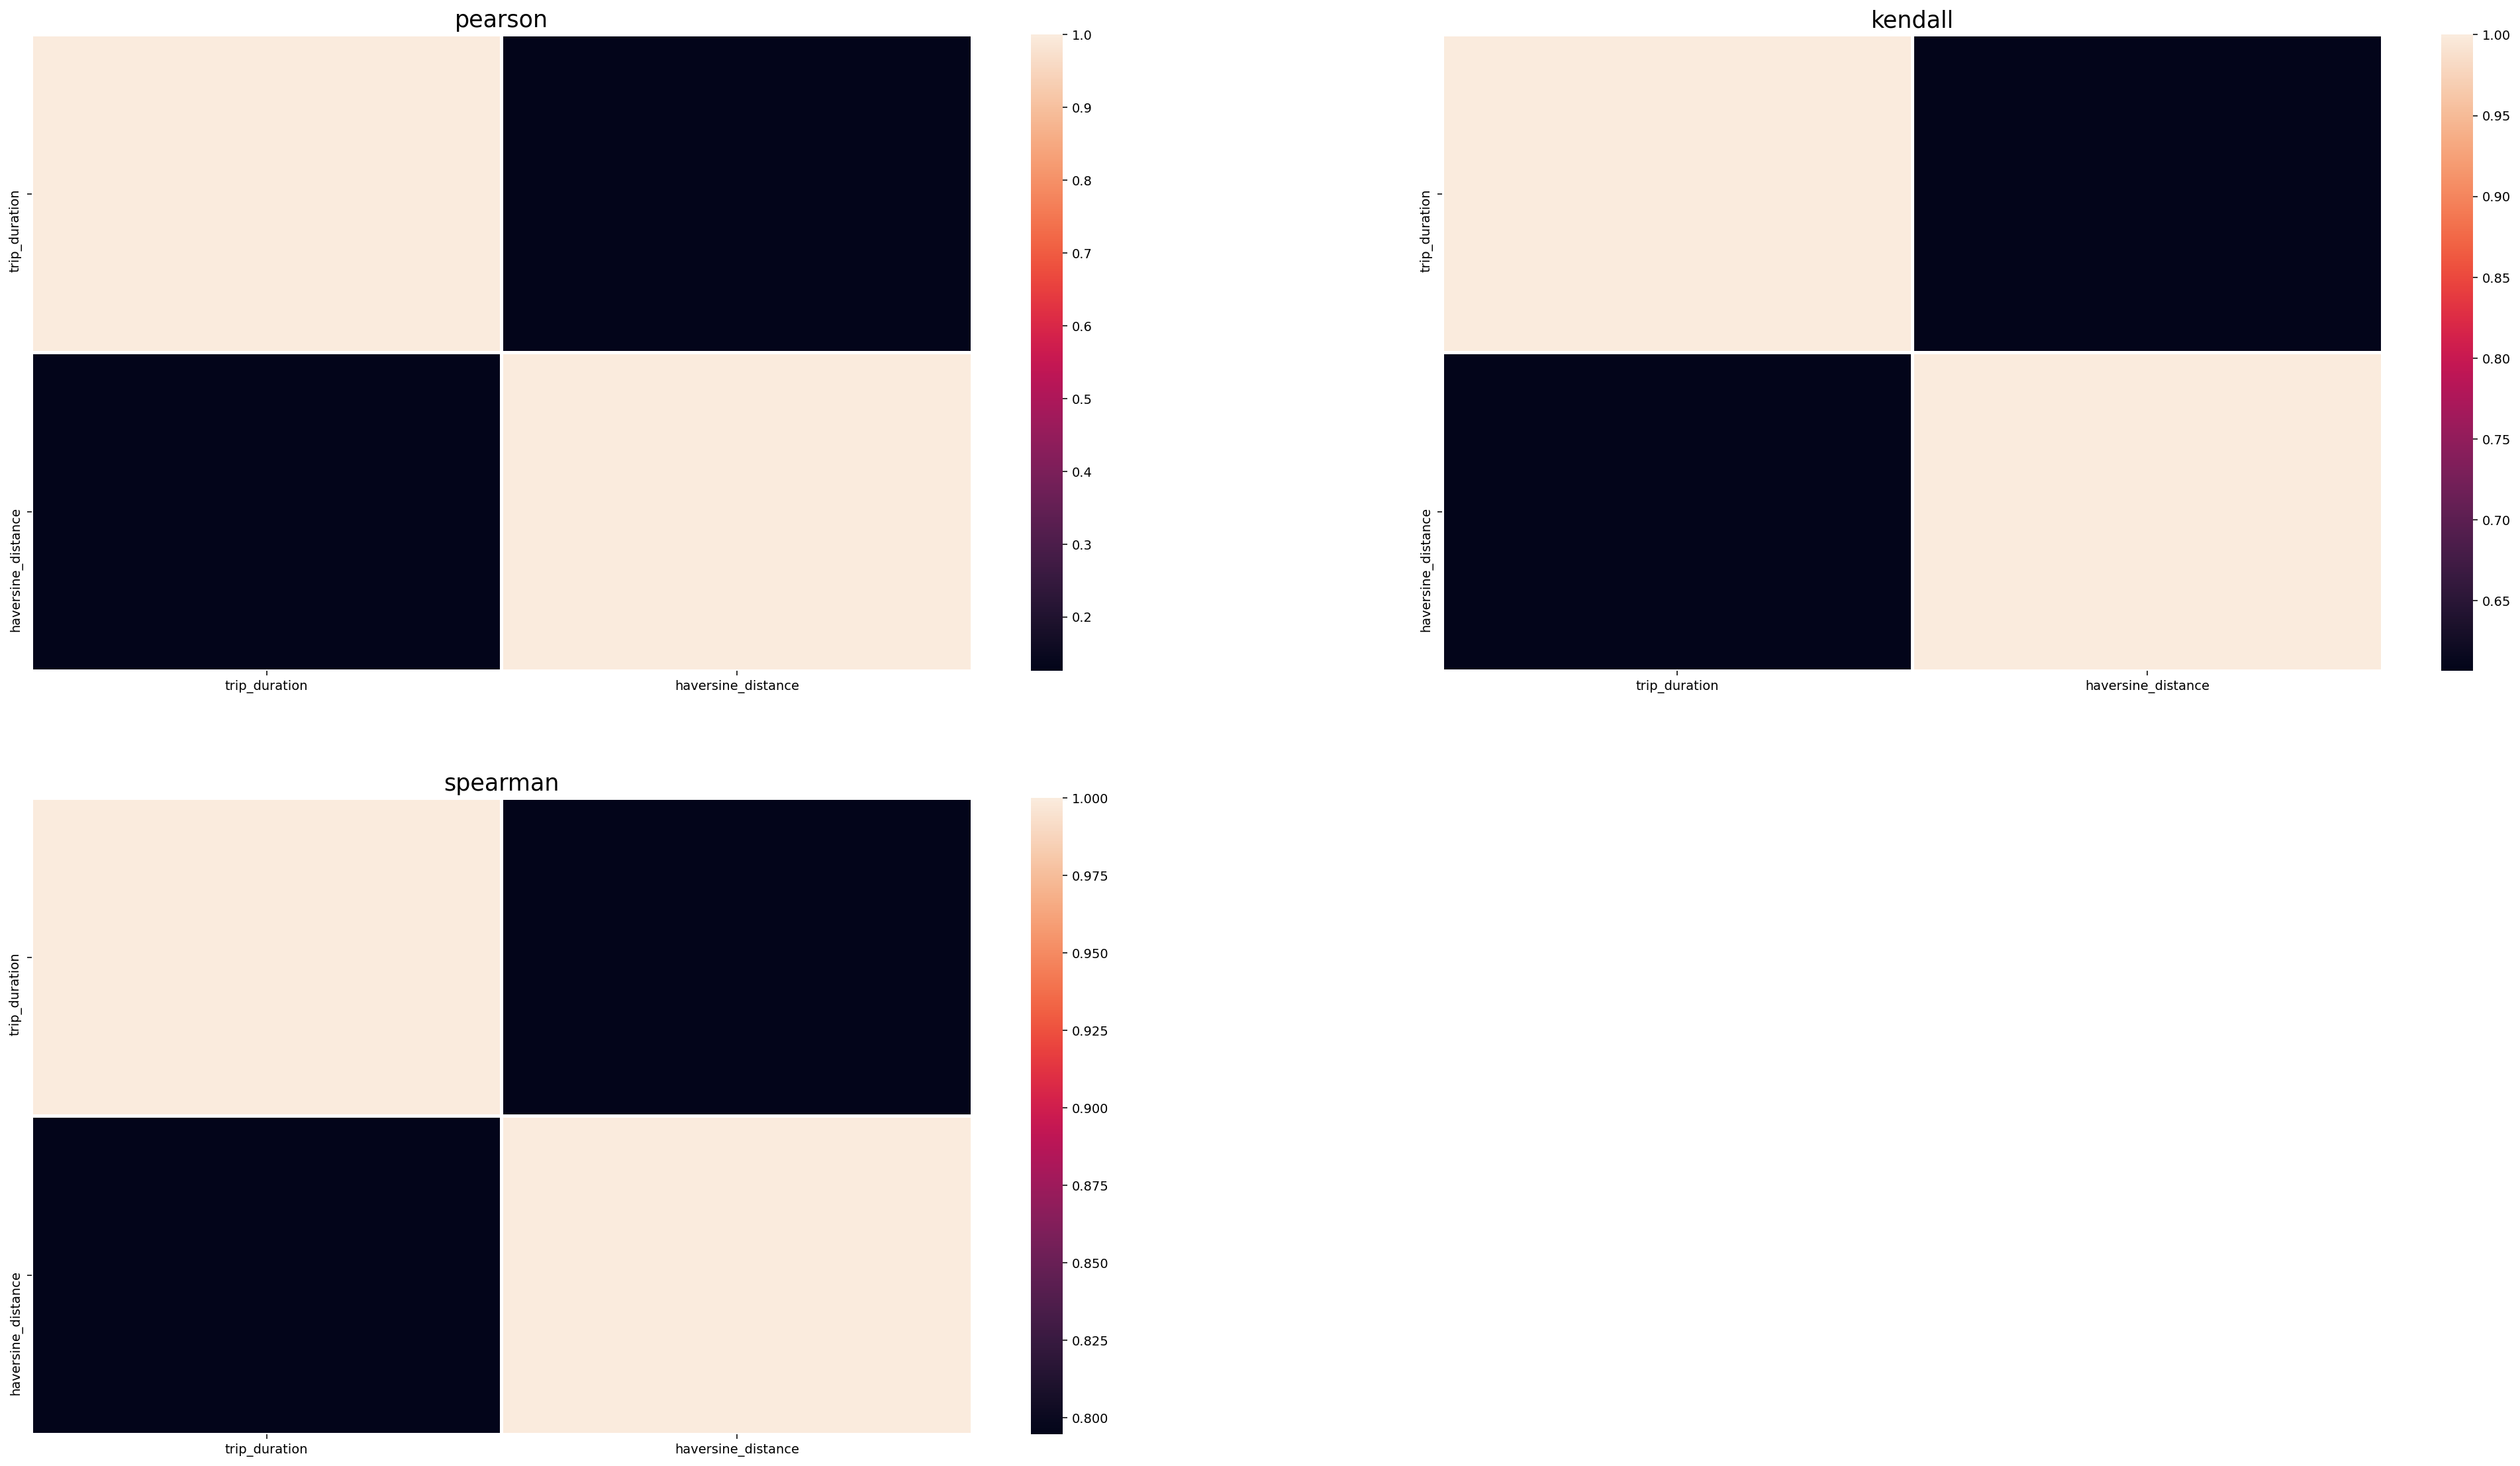

In [52]:
# plotting heatmap usill all methods for all numerical variables
plt.figure(figsize=(36,20), dpi=140)
for j,i in enumerate(['pearson','kendall','spearman']):
  plt.subplot(2,2,j+1)
  correlation = continous.corr(method=i)
  sns.heatmap(correlation, linewidth = 2)
  plt.title(i, fontsize=18)

Correlation between these variables seems to be higher. 

### Categorical-Categorical 

In [53]:
data.select_dtypes(include=['object','category']).dtypes

vendor_id             category
passenger_count       category
store_and_fwd_flag      object
woy_pickup            category
moy_pickup            category
dow_pickup            category
woy_dropoff           category
moy_dropoff           category
dow_dropoff           category
timeofday_pickup      category
timeofday_dropoff     category
dtype: object

In [54]:
def BVA_categorical_plot(data, tar, cat):
  '''
  take data and two categorical variables,
  calculates the chi2 significance between the two variables 
  and prints the result with countplot & CrossTab
  '''
  #isolating the variables
  data = data[[cat,tar]][:]

  #forming a crosstab
  table = pd.crosstab(data[tar],data[cat],)
  f_obs = np.array([table.iloc[0][:].values,
                    table.iloc[1][:].values])

  #performing chi2 test
  from scipy.stats import chi2_contingency
  chi, p, dof, expected = chi2_contingency(f_obs)
  
  #checking whether results are significant
  if p<0.05:
    sig = True
  else:
    sig = False

  #plotting grouped plot
  sns.countplot(x=cat, hue=tar, data=data)
  plt.title("p-value = {}\n difference significant? = {}\n".format(round(p,8),sig))

  #plotting percent stacked bar plot
  #sns.catplot(ax, kind='stacked')
  ax1 = data.groupby(cat)[tar].value_counts(normalize=True).unstack()
  ax1.plot(kind='bar', stacked='True',title=str(ax1))
  int_level = data[cat].value_counts()

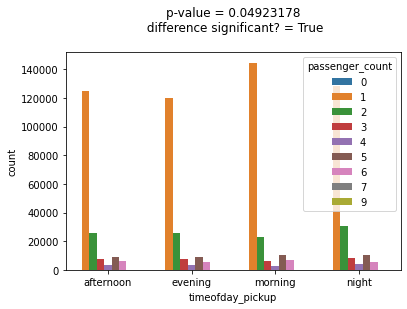

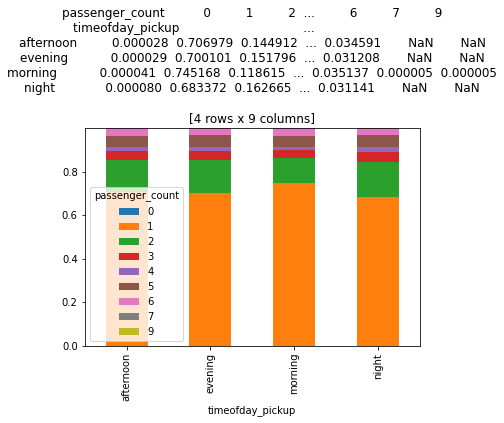

In [55]:
BVA_categorical_plot(data,'passenger_count','timeofday_pickup')

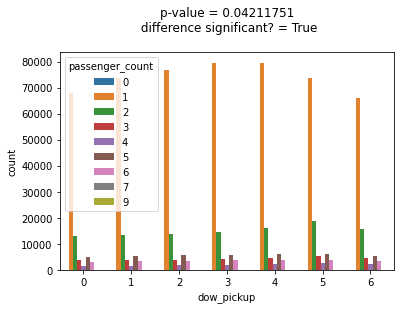

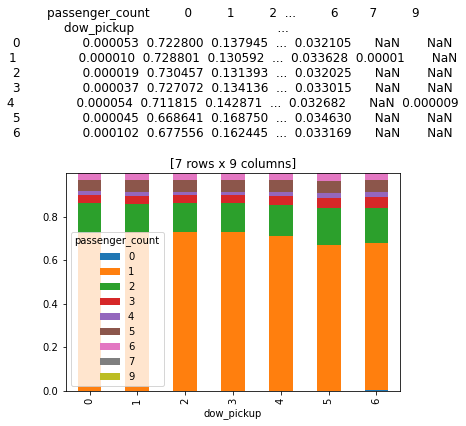

In [56]:
BVA_categorical_plot(data,'passenger_count','dow_pickup')

### Continous - Categorical

In [57]:
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sampled Z-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import norm
  ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
  z = (X1 - X2)/ovr_sigma
  pval = 2*(1 - norm.cdf(abs(z)))
  return pval

In [58]:
def TwoSampT(X1, X2, sd1, sd2, n1, n2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sample T-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import t as t_dist
  ovr_sd = sqrt(sd1**2/n1 + sd2**2/n2)
  t = (X1 - X2)/ovr_sd
  df = n1+n2-2
  pval = 2*(1 - t_dist.cdf(abs(t),df))
  return pval

In [59]:
def Bivariate_cont_cat(data, cont, cat, category):
  #creating 2 samples
  x1 = data[cont][data[cat]==category][:]
  x2 = data[cont][~(data[cat]==category)][:]
  
  #calculating descriptives
  n1, n2 = x1.shape[0], x2.shape[0]
  m1, m2 = x1.mean(), x2.mean()
  std1, std2 = x1.std(), x2.mean()
  
  #calculating p-values
  t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
  z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)

  #table
  table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)

  #plotting
  plt.figure(figsize = (15,6), dpi=140)
  
  #barplot
  plt.subplot(1,2,1)
  sns.barplot([str(category),'not {}'.format(category)], [m1, m2])
  plt.ylabel('mean {}'.format(cont))
  plt.xlabel(cat)
  plt.title('t-test p-value = {} \n z-test p-value = {}\n {}'.format(t_p_val,
                                                                z_p_val,
                                                                table))

  # boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x=cat, y=cont, data=data)
  plt.title('categorical boxplot')
  

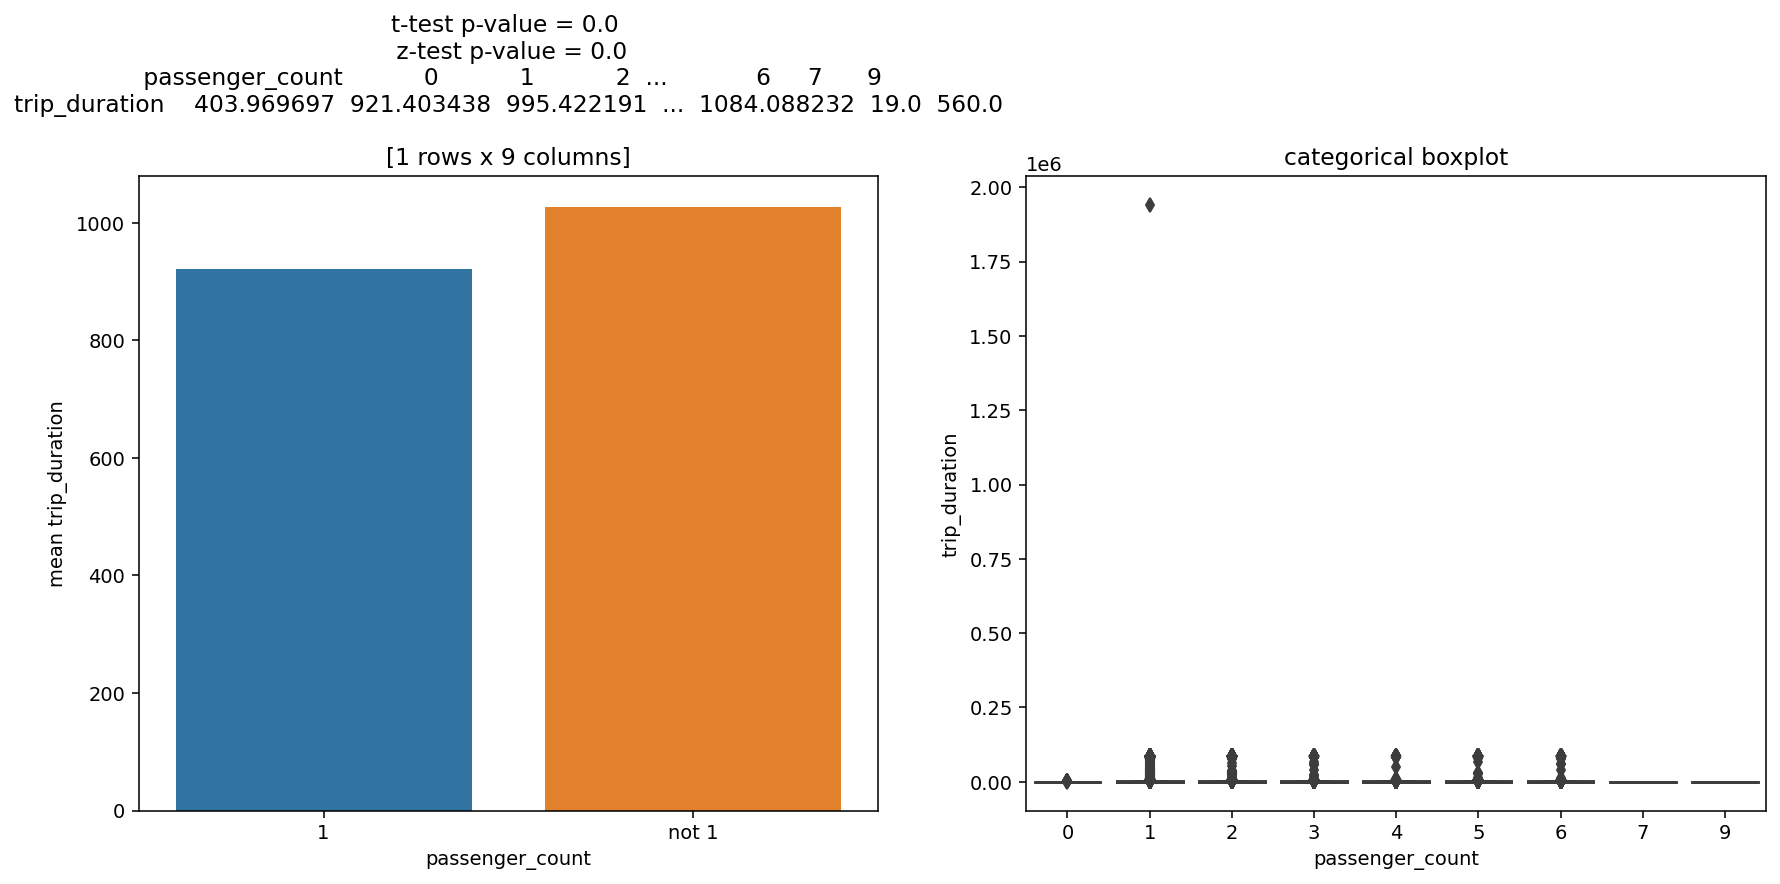

In [60]:
Bivariate_cont_cat(data,'trip_duration','passenger_count',1)

## Preprocessing the data

In [61]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,woy_pickup,moy_pickup,dow_pickup,woy_dropoff,moy_dropoff,dow_dropoff,timeofday_pickup,timeofday_dropoff,haversine_distance
0,2,1,N,400,9,2,0,9,2,0,afternoon,afternoon,1.199073
1,1,2,N,1100,10,3,4,10,3,4,night,night,4.129111
2,2,2,N,1635,7,2,6,7,2,6,evening,evening,7.250753
3,2,6,N,1141,1,1,1,1,1,1,morning,morning,2.361097
4,1,1,N,848,7,2,2,7,2,2,morning,morning,4.328534


In [62]:
data.dtypes

vendor_id             category
passenger_count       category
store_and_fwd_flag      object
trip_duration            int64
woy_pickup            category
moy_pickup            category
dow_pickup            category
woy_dropoff           category
moy_dropoff           category
dow_dropoff           category
timeofday_pickup      category
timeofday_dropoff     category
haversine_distance     float64
dtype: object

In [63]:
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].astype('category')

In [64]:
data.dtypes

vendor_id             category
passenger_count       category
store_and_fwd_flag    category
trip_duration            int64
woy_pickup            category
moy_pickup            category
dow_pickup            category
woy_dropoff           category
moy_dropoff           category
dow_dropoff           category
timeofday_pickup      category
timeofday_dropoff     category
haversine_distance     float64
dtype: object

### Imputing Outliers

In [65]:
#function for outlier analysis
def outlier_removal(data, var_group):
    
    size = len(var_group)
    plt.figure(figsize = (7*size,4),dpi=100)
    
    
    #looping for each variable
    for j,i in enumerate(var_group):
        #calculating descriptives of variable(like IQR, 25th quantile, 75th quantile)
        quant25 = data[i].quantile(0.25)
        quant75 = data[i].quantile(0.75)
        IQR = quant75 - quant25
        med = data[i].median()
        whis_low = quant25 - (1.5 * IQR)
        whis_high = quant75 + (1.5 * IQR)
        
        outlier_high = len(data[i][data[i]>whis_high])
        outlier_low = len(data[i][data[i]<whis_low])
        
        # replacing outliers with min/max whisker
        data[i][data[i]>whis_high] = whis_high 
        data[i][data[i]<whis_low] = whis_low 
            
        #plotting without outliers
        plt.subplot(1,size,j+1)
        sns.boxplot(data[i], orient="v")
        plt.ylabel('{}'.format(i))
        plt.title('Without Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))
            

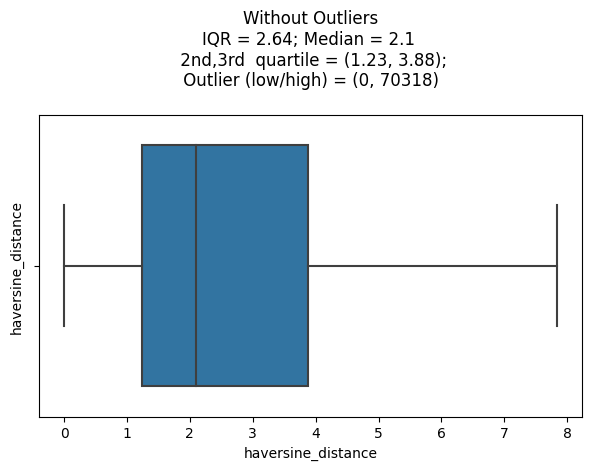

In [66]:
outlier_removal(data,['haversine_distance'])

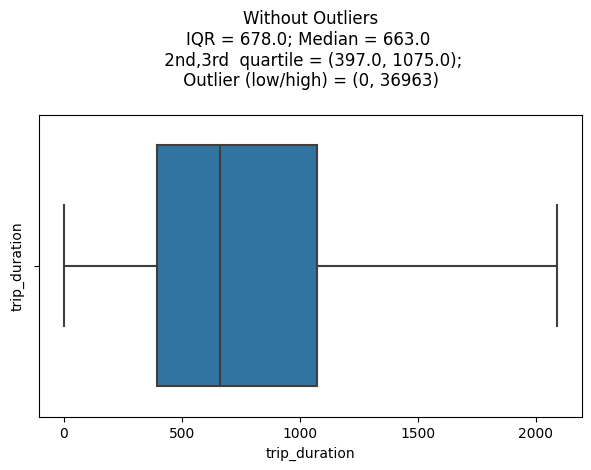

In [67]:
outlier_removal(data,['trip_duration'])

In [68]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,woy_pickup,moy_pickup,dow_pickup,woy_dropoff,moy_dropoff,dow_dropoff,timeofday_pickup,timeofday_dropoff,haversine_distance
0,2,1,N,400,9,2,0,9,2,0,afternoon,afternoon,1.199073
1,1,2,N,1100,10,3,4,10,3,4,night,night,4.129111
2,2,2,N,1635,7,2,6,7,2,6,evening,evening,7.250753
3,2,6,N,1141,1,1,1,1,1,1,morning,morning,2.361097
4,1,1,N,848,7,2,2,7,2,2,morning,morning,4.328534


In [69]:
data_clean = pd.get_dummies(data)

In [70]:
data_clean = data_clean.sample(frac=0.5,replace= True,random_state =1)
data_clean.reset_index(inplace=True,drop=True)

### Segregating Variables: Independent and Dependant Variable

In [71]:
x = data_clean.drop(columns=['trip_duration'],axis=1)
y = data_clean['trip_duration']
x.shape,y.shape

((364661, 103), (364661,))

# Linear Regression

### Splitting the data into train and test set

In [72]:
from sklearn.model_selection import train_test_split as tts
train_x,test_x,train_y,test_y = tts(x,y,random_state = 45)

### Splitting train set to create a validation set

In [73]:
train1_x,val_x,train1_y,val_y = tts(train_x,train_y,random_state = 45)

### Implementing Linear Regression

In [74]:
#importing linear regression and mean squared error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as mse

In [75]:
# Creating an instance of linear regression 
lr = LR()
#fitting the model
lr.fit(train1_x,train1_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [76]:
train1_predict = lr.predict(train1_x)
k = mse(train1_predict,train1_y,squared=False)
print('RMSE:',k)

RMSE: 308.57076174336083


In [77]:
val_predict = lr.predict(val_x)
k = mse(val_predict,val_y,squared=False)
print('RMSE:',k)

RMSE: 307.4727961016895


In [78]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(lr,X = train1_x, y = train1_y,cv =10)
score

array([0.65013568, 0.65270042, 0.66204393, 0.6603745 , 0.5402744 ,
       0.64426085, 0.6628453 , 0.65313695, 0.65454183, 0.66785155])

In [79]:
score.mean()*100, score.std()*100

(64.48165408759507, 3.5465629567088754)

In [80]:
lr.coef_

array([ 1.87348476e+02, -2.00227387e+00,  2.00227402e+00, -8.80526603e+01,
       -2.35134207e+00,  2.30116678e+01,  2.58971192e+01,  3.83755425e+01,
        2.59964413e+00,  5.20028652e-01,  2.73740852e-09, -1.49816515e-09,
       -4.96811348e+00,  4.96811349e+00,  4.26065383e+03,  3.19377214e+03,
        1.25736245e+03, -2.16185167e+02,  1.51000556e+04,  1.40045267e+04,
        1.27263590e+04,  1.10958697e+04,  9.39236541e+03,  7.74065436e+03,
        6.27986996e+03,  5.05795341e+03,  3.05543723e+03,  1.39933899e+03,
       -2.53203988e+02, -1.90696566e+03, -3.26293923e+03, -4.83515843e+03,
       -6.42527814e+03, -7.81580468e+03, -9.12724774e+03, -1.06046134e+04,
       -1.23194027e+04, -1.33698104e+04, -1.43407286e+04, -1.59055379e+04,
        5.81865737e+03,  1.43142606e+04, -2.21281409e+03, -2.74032843e+03,
       -2.98572424e+03, -3.05978859e+03, -3.31560528e+03,  4.56906056e+02,
        3.55004494e+02,  2.23435880e+02,  1.24108605e+02, -3.90286865e+01,
       -3.68127620e+02, -

## Plotting the Coefficients

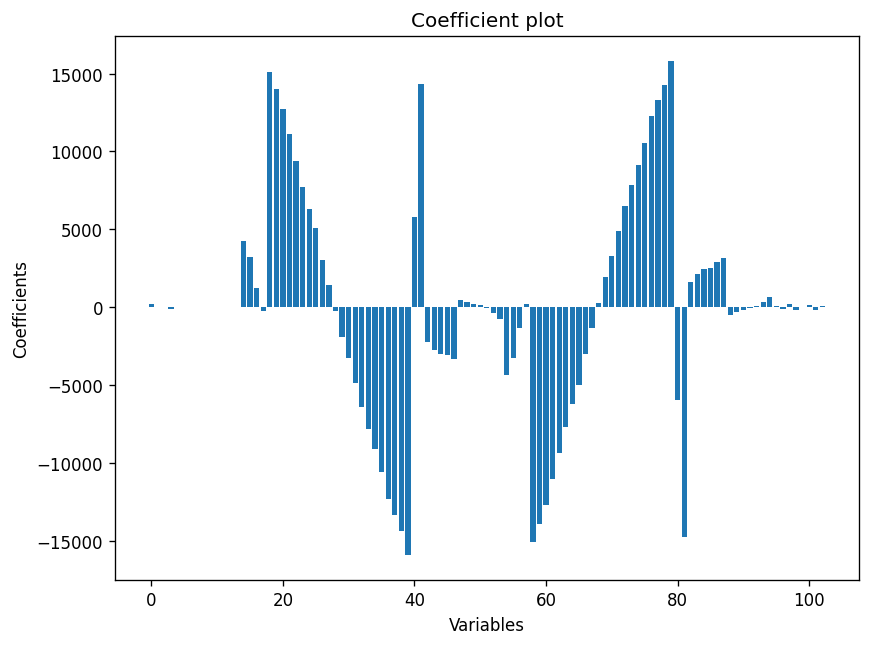

In [81]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot');

Here we can see that the model depends upon some Independent variables toos much, But these coefficients are not suitable for interpretation because these are not scaled.


## Checking the assumptions of the Linear Model


In [82]:
#arranging and calculating the residuals.
residuals = pd.DataFrame({
    'Fitted_Values' : val_y,
    'Predicted_Values': val_predict
})

residuals['residuals'] = residuals['Fitted_Values'] - residuals['Predicted_Values']
residuals.head()

,Fitted_Values,Predicted_Values,residuals
163437,234,427.318896,-193.318896
116368,1127,1492.528494,-365.528494
296526,399,283.195997,115.804003
315310,1222,1031.235835,190.764165
159403,1235,938.562796,296.437204


In [83]:
residuals.shape

(68374, 3)

### Plotting residual curve(Is there constant Variance or Homoscedastic?)

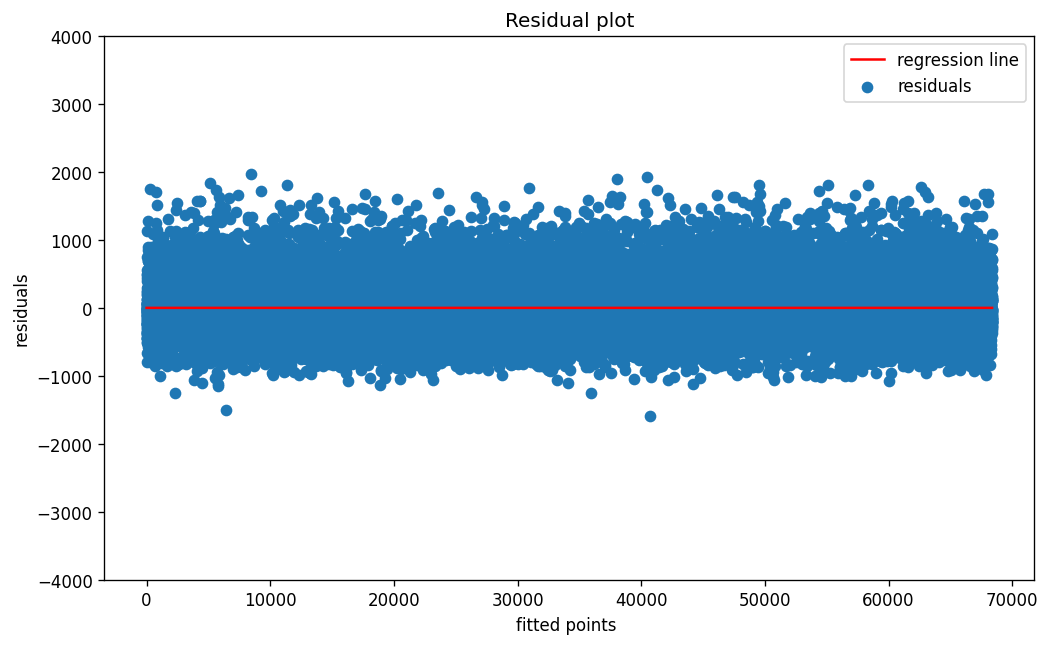

In [84]:
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,68374)
k = [0 for i in range(0,68374)]
plt.scatter( f, residuals.residuals[:], label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.ylim(-4000, 4000)
plt.legend();

The Residual plot clearly Looks Homoscedastic, i.e. the the variance of the error across the dataset is nearly constant.

## Checking distribution of Residuals

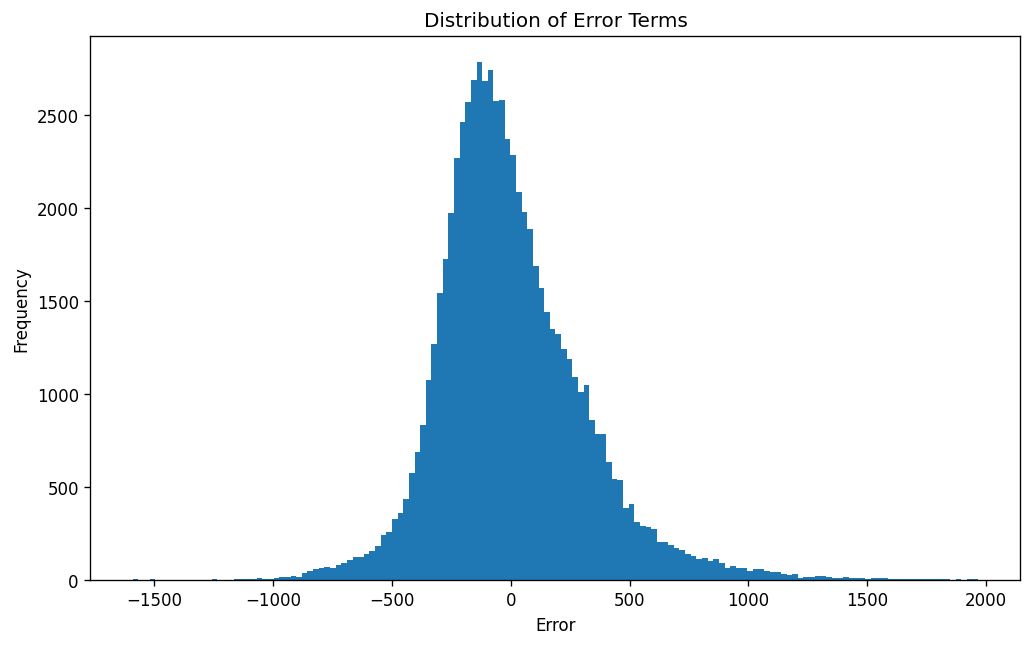

In [85]:
# Histogram for distribution
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
plt.hist(residuals.residuals, bins = 150)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
plt.show()

According to the Histogram, the distribution of error seems to be nearly normal.

### QQ-Plot(Is the data Normally Distributed?)

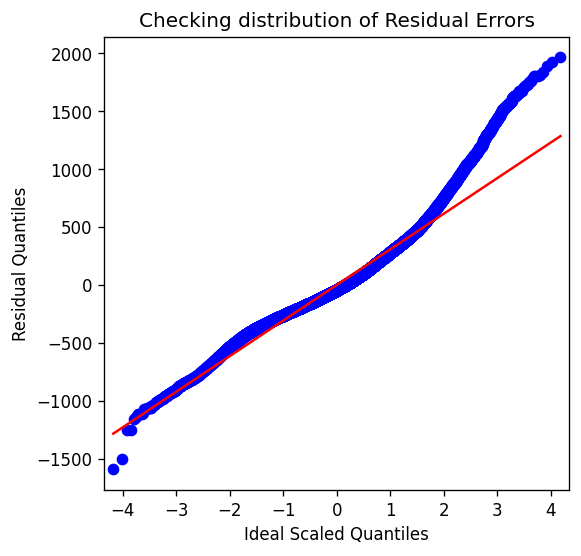

In [86]:
#importing the qq ploot from the statsmodel
from statsmodels.graphics.gofplots import qqplot

##Plotting the qq-plot
fig,ax =plt.subplots(figsize=(5,5),dpi=120)
qqplot(residuals.residuals,line ='s',ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')
plt.show()

The QQ-plot clearly verifies our findings from the the histogram of the residuals, the data is mostly normal in nature, but there sre some outliers on the higher end of the Residues.

## Model Interpretability

So far we have simply been predicting the values using the linear regression, But in order to Interpret the model, the normalising of the data is essential.

In [87]:
#creating the instance of Linear Regression
lr = LR(normalize=True)

# fitting the model
lr.fit(train1_x,train1_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [88]:
# Predicting over the train set and calculating the error
train1_predict = lr.predict(train1_x)
k = mse(train1_predict,train1_y,squared=False)
print("Train RMSE:",k)

Train RMSE: 308.6429636962444


In [89]:
val_predict = lr.predict(val_x)
k = mse(val_predict,val_y,squared=False)
print('Validation RMSE:',k)

Validation RMSE: 307.5284799466479


Text(0.5, 1.0, 'Normalized Coefficient plot')

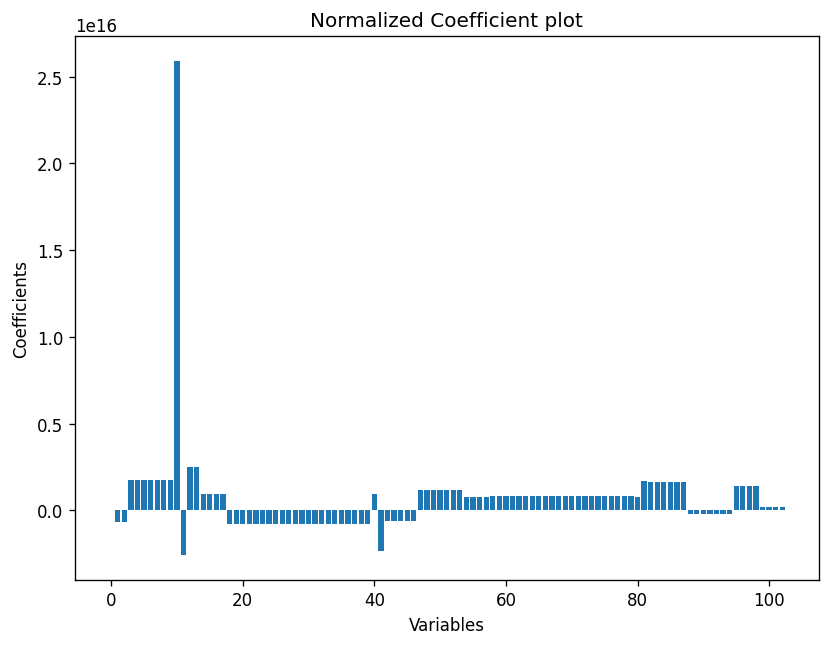

In [90]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train1_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot')

Now the coefficients we see are normalised and we can easily make final inferences out of it.

Here we can see that there are a lot of Coefficients which are near to zero and not Significant. So let us try removing them and build the model again.

## Creating a new subset of data

In [91]:
# separating the independent and dependent variables
x = data_clean.drop(['trip_duration'],axis=1)
y = data_clean['trip_duration']
x.shape , y.shape

((364661, 103), (364661,))

### Arranging coefficients with features

In [92]:
Coefficients = pd.DataFrame({
    'Variable'    : x.columns,
    'coefficient' : lr.coef_
})
Coefficients.head()

,Variable,coefficient
0,haversine_distance,1.873497e+02
1,vendor_id_1,-6.934475e+14
2,vendor_id_2,-6.934475e+14
3,passenger_count_0,1.754762e+15
4,passenger_count_1,1.754762e+15


### Chossing variables with sigificance greater than 0.5 ( Filtering Significant Features)

In [93]:
sig_var = Coefficients[Coefficients.coefficient > 1]
sig_var

,Variable,coefficient
0,haversine_distance,1.873497e+02
3,passenger_count_0,1.754762e+15
4,passenger_count_1,1.754762e+15
5,passenger_count_2,1.754762e+15
6,passenger_count_3,1.754762e+15
...,...,...
98,timeofday_pickup_night,1.389663e+15
99,timeofday_dropoff_afternoon,1.885437e+14
100,timeofday_dropoff_evening,1.885437e+14
101,timeofday_dropoff_morning,1.885437e+14


In [94]:
subset = data_clean[sig_var['Variable'].values]
subset.head()

,haversine_distance,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,store_and_fwd_flag_N,store_and_fwd_flag_Y,woy_pickup_1,woy_pickup_2,woy_pickup_3,woy_pickup_4,woy_pickup_53,dow_pickup_0,dow_pickup_1,dow_pickup_2,dow_pickup_3,dow_pickup_4,dow_pickup_5,dow_pickup_6,woy_dropoff_1,woy_dropoff_2,woy_dropoff_3,woy_dropoff_4,woy_dropoff_5,woy_dropoff_6,woy_dropoff_7,woy_dropoff_8,woy_dropoff_9,woy_dropoff_10,woy_dropoff_11,woy_dropoff_12,woy_dropoff_13,woy_dropoff_14,woy_dropoff_15,woy_dropoff_16,woy_dropoff_17,woy_dropoff_18,woy_dropoff_19,woy_dropoff_20,woy_dropoff_21,woy_dropoff_22,woy_dropoff_23,woy_dropoff_24,woy_dropoff_25,woy_dropoff_26,woy_dropoff_53,moy_dropoff_1,moy_dropoff_2,moy_dropoff_3,moy_dropoff_4,moy_dropoff_5,moy_dropoff_6,moy_dropoff_7,timeofday_pickup_afternoon,timeofday_pickup_evening,timeofday_pickup_morning,timeofday_pickup_night,timeofday_dropoff_afternoon,timeofday_dropoff_evening,timeofday_dropoff_morning,timeofday_dropoff_night
0,1.261897,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,3.451377,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,0.512178,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
3,1.737687,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,5.106971,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1


### Splitting the data into train set and the test set

In [95]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(subset, y , random_state = 56)

### Training Model

In [96]:
# Creating instance of Linear Regresssion with Normalised Data
lr = LR(normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

### Predicting over the train set

In [97]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mse(train_predict, train_y,squared= False)
print('Training RMSE:', k )

Training RMSE: 309.9504277008654


### Predicting over the test set

In [98]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mse(test_predict, test_y,squared=False)
print('Test RMSE: ', k )

Test RMSE:  308.3751329757727


###Plotting the coefficients

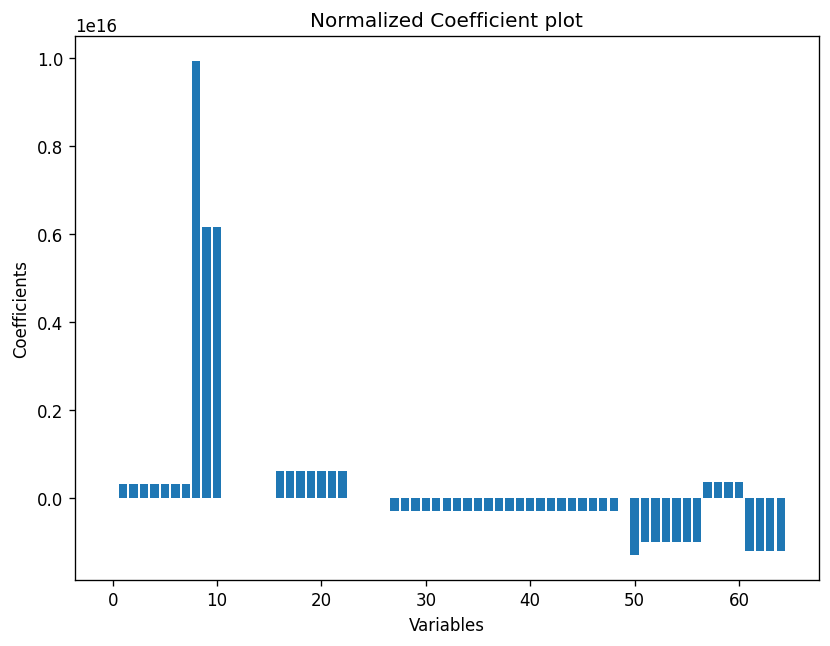

In [99]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot');

In [100]:
lr.coef_.shape

(65,)

# Regularisation: Ridge

In [101]:
a = data_clean.drop(columns=['trip_duration'],axis=1)
b = data_clean['trip_duration']
a.shape,b.shape

((364661, 103), (364661,))

In [102]:
train_x,test_x,train_y,test_y = tts(a,b,random_state = 45)

In [103]:
# Importing ridge from sklearn's linear_model module
from sklearn.linear_model import Ridge

In [104]:
#Set the different values of alpha to be tested
alpha_ridge = [0, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 25]
alpha_ridge

[0, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 10, 20, 25]

In [105]:
result =[]
for alpha in alpha_ridge:
    ret =[]
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(train_x,train_y)
    train_y_pred = ridgereg.predict(train_x)
    test_y_pred = ridgereg.predict(test_x)
    
    #Return the result in pre-defined format
    mrss_train = sum((train_y_pred-train_y)**2)/train_x.shape[0]
    ret = [math.sqrt(mrss_train)]
        
    mrss_test = sum((test_y_pred-test_y)**2)/test_x.shape[0]
    ret.extend([math.sqrt(mrss_test)])
    ret.extend([ridgereg.intercept_])
    result.append(ret)

In [106]:
result

[[308.27451121526684, 308.88756800836285, -1049293928249645.6],
 [308.2738243832576, 308.8858674821478, 266.7429649351909],
 [309.00784203189096, 309.7128949888473, 265.2847373611629],
 [309.1099024646926, 309.6881240628216, 265.7542007910016],
 [309.43109709876506, 309.904317184644, 271.2699044855319],
 [377.1932418020559, 378.1896370126612, 564.571365107793],
 [471.6403887476823, 472.3931847062081, 733.7255536474636],
 [496.3384218880673, 496.9974170909832, 766.5369760246202],
 [510.935344504892, 511.5359934626692, 784.0094141645732],
 [514.0711491780947, 514.6590412020607, 787.5737897980312]]

In [107]:
# defining a function which will fit ridge regression model, plot the results, and return the coefficients
def ridge_regression(train_x, train_y, test_x, test_y, alpha):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(train_x,train_y)
    train_y_pred = ridgereg.predict(train_x)
    test_y_pred = ridgereg.predict(test_x)
    
    
    #Return the result in pre-defined format
    mrss_train = sum((train_y_pred-train_y)**2)/train_x.shape[0]
    ret = [math.sqrt(mrss_train)]
    
    mrss_test = sum((test_y_pred-test_y)**2)/test_x.shape[0]
    ret.extend([math.sqrt(mrss_test)])
    
    ret.extend([ridgereg.intercept_])
    #ret.extend(ridgereg.coef_)
    
    return ret

In [108]:
#Initialize the dataframe for storing coefficients.
col = ['mrss_train','mrss_test','intercept'] 
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

In [109]:
#Define the alpha value for which a plot is required:
models_to_plot = {0:231, 1e-4:232, 1e-3:233, 1e-2:234, 1:235, 5:236}

In [110]:
#a=ridge_regression(train_x, train_y, test_x, test_y, alpha_ridge[2])

In [111]:
#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_ridge.iloc[i] = ridge_regression(train_x, train_y, test_x, test_y, alpha_ridge[i])

In [112]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.6g}'.format
coef_matrix_ridge

,mrss_train,mrss_test,intercept
alpha_0,308.275,308.888,-1.04929e+15
alpha_1e-08,308.274,308.886,266.743
alpha_0.0001,309.008,309.713,265.285
alpha_0.001,309.11,309.688,265.754
alpha_0.01,309.431,309.904,271.27
alpha_1,377.193,378.19,564.571
alpha_5,471.64,472.393,733.726
alpha_10,496.338,496.997,766.537
alpha_20,510.935,511.536,784.009
alpha_25,514.071,514.659,787.574


In [113]:
coef_matrix_ridge['mrss_train']

alpha_0        308.275
alpha_1e-08    308.274
alpha_0.0001   309.008
alpha_0.001     309.11
alpha_0.01     309.431
alpha_1        377.193
alpha_5         471.64
alpha_10       496.338
alpha_20       510.935
alpha_25       514.071
Name: mrss_train, dtype: object

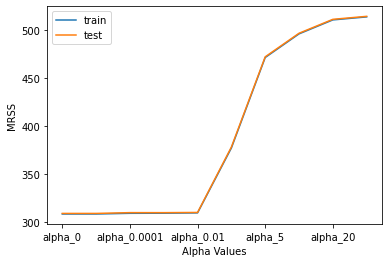

In [114]:
coef_matrix_ridge[['mrss_train','mrss_test']].plot()
plt.xlabel('Alpha Values')
plt.ylabel('MRSS')
plt.legend(['train', 'test'])

#XGBOOST Model

In [115]:
from xgboost import XGBRegressor


In [145]:
from sklearn.metrics import r2_score

In [119]:
xgbm = XGBRegressor()

In [120]:
xgbm.fit(train_x,train_y)

[05:21:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [146]:
trainpred= xgbm.predict(train_x)

In [123]:
mse(train_y,trainpred,squared=False)

297.00508346163326

In [148]:
r2_score(train_y,trainpred)

0.6829143648790545

##Hyperparameter Tuning

In [124]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [127]:
parametersXGBM={
    'learning_rate':[0.1,0.5,0.8],
    'n_estimators':[75,100,125,150],
    'subsample':[0.5,0.7,0.9,1],
    'max_depth':[2,3,4],
    'objective':['reg:squarederror'],
    'colsample_bylevel':[0.5,0.7,0.8,0.9,1],
    'colsample_bytree':[0.5,0.7,0.8,0.9,1]
    #'reg_alpha':[i/10 for i in range(1,100)]+[i/100 for i in range(1,100)]+[i/1000 for i in range(1,100)],
    #'min_child_weight':range(1,6)
}

In [130]:
#gridSearch= GridSearchCV(estimator=xgbm,param_grid=parametersXGBM,scoring='neg_mean_squared_error', cv=5)

In [131]:
#gridSearch.fit(train_x,train_y)

In [134]:
randomSearch = RandomizedSearchCV(estimator=xgbm,param_distributions=parametersXGBM,n_iter=10,cv=5,n_jobs=-1,random_state=55)

In [135]:
randomSearch.fit(train_x,train_y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.5, 0.7, 0.8,
                                                    

In [136]:
randomSearch.best_params_

{'colsample_bylevel': 0.5,
 'colsample_bytree': 1,
 'learning_rate': 0.5,
 'max_depth': 4,
 'n_estimators': 125,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

In [137]:
randomSearch.best_score_

0.6925606893400504

In [138]:
XGBM=XGBRegressor(n_estimators=125,max_depth=4,learning_rate=0.5,objective='reg:squarederror',colsample_bylevel=0.5,colsample_bytree=1,subsample=0.9,random_state=45)

In [139]:
XGBM.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=125,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=45, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, verbosity=1)

In [143]:
trainpreds=XGBM.predict(train_x)

In [150]:
mse(train_y,trainpreds,squared=False)

288.36432877605097

In [151]:
r2_score(train_y,trainpreds)

0.7010958980689636

In [153]:
testpreds = XGBM.predict(test_x)

In [154]:
mse(test_y,testpreds,squared=False)

292.248205500755

In [155]:
r2_score(test_y,testpreds)

0.6936062569498794